In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [2]:
weather_data <- read_csv("data/testing_set.csv")
weather_data


weather_split <- initial_split(weather_data, prop = 0.75, strata = Weather)
weather_train = training(weather_split)
weather_test = testing(weather_split)

Parsed with column specification:
cols(
  Temp = col_double(),
  Humid = col_double(),
  Wind_Spd = col_double(),
  Vis = col_double(),
  Press = col_double(),
  Weather = col_character()
)



Temp,Humid,Wind_Spd,Vis,Press,Weather
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
12.8,100,4,32.2,101.78,Mostly Cloudy
10.4,100,4,32.2,101.72,Mostly Cloudy
15.3,80,3,48.3,101.72,Mostly Cloudy
⋮,⋮,⋮,⋮,⋮,⋮
17.3,72,9,48.3,102.19,Mostly Cloudy
16.4,69,15,32.2,102.14,Mainly Clear
14.6,83,13,32.2,102.24,Mostly Cloudy


`summarise()` ungrouping output (override with `.groups` argument)



Weather,n
<chr>,<int>
Clear,73
Cloudy,623
Heavy Rain,13
⋮,⋮
Mostly Cloudy,803
Rain,773
Rain Showers,233


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,1,5,0,Model01
2,accuracy,multiclass,1,5,0,Model02
3,accuracy,multiclass,1,5,0,Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
8,accuracy,multiclass,1.0000000,5,0.000000000,Model08
9,accuracy,multiclass,0.9982964,5,0.001703578,Model09
10,accuracy,multiclass,0.9982964,5,0.001703578,Model10


ERROR: Error in eval(lhs, parent, parent): '...' used in an incorrect context


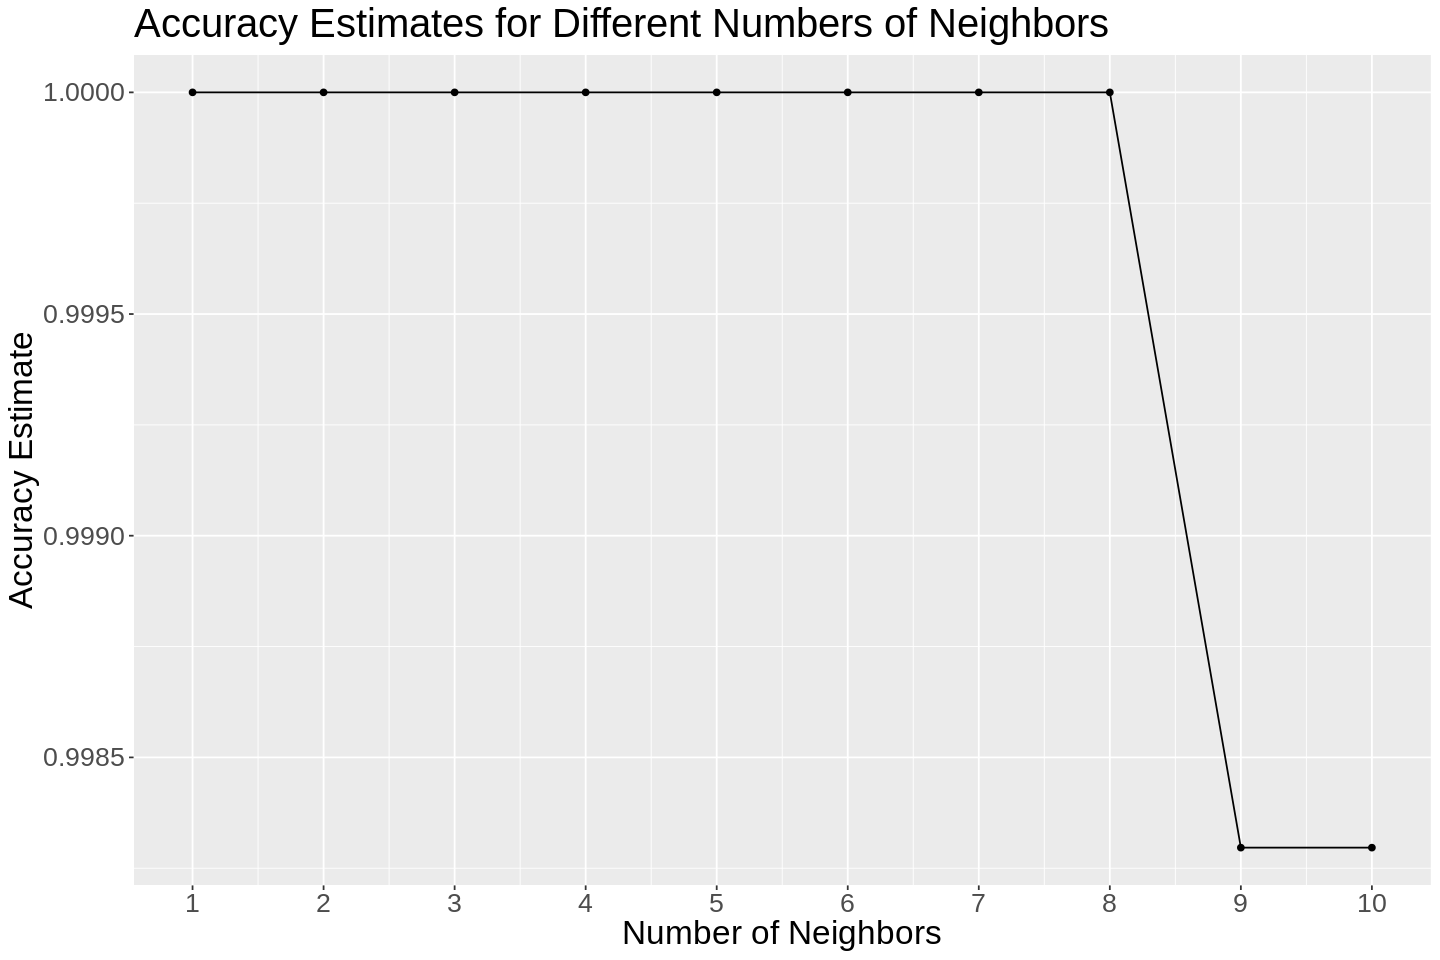

In [3]:
set.seed(2022)


#check to see if proportions of data are close enough to use or if we should scale up / remove some
#of the other weather classifications

number_rows <- nrow(weather_train)

proportions <- weather_train %>%
    group_by(Weather) %>%
    summarize(n = n())
proportions

#make recipe and model with cross validation to find k

weather_recipe <- recipe(Weather ~ ., data = weather_train) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

weather_knn <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

weather_vfold <- vfold_cv(weather_train, v = 5, strata = Weather)

k_grid <- tibble(neighbors = 1:10)

weather_fit <- workflow() %>%
    add_recipe(weather_recipe) %>%
    add_model(weather_knn) %>%
    tune_grid(resamples = weather_vfold, grid = k_grid) %>%
    collect_metrics()

#find accuracy for different values of k on our model

weather_accuracy <- weather_fit %>%
    filter(.metric == "accuracy")
weather_accuracy

#create line plot with data points for accuracy estimate vs neighbors to find optimal k value
#(looking for high accuracy estimate with high values of accuracy for nearby values of k as well)

options(repr.plot.height = 8, repr.plot.width = 12)
finding_k_plot <- ggplot(weather_accuracy, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Number of Neighbors", y = "Accuracy Estimate",
        title = "Accuracy Estimates for Different Numbers of Neighbors") +
    theme(text = element_text(size = 20)) +
    scale_x_continuous(breaks = 1:10)
finding_k_plot

#retrain our model with the newfound value of k and fit it to our training data

weather_model <- nearest_neighbor(weight_func = "rectangular", neighbors = ...) %>%  ## must use value of k determined above
    set_engine("kknn") %>%
    set_mode("classification")

weather_fit_final <- workflow() %>%
    add_recipe(weather_recipe) %>%
    add_model(weather_model) %>%
    fit(data = weather_train)

#we can now use our fitted model to predict the weather for our testing data set

weather_predictions <- predict(weather_fit_final, weather_test) %>%
    bind_cols(weather_test) %>%
    select(.pred_class, Weather) %>%
weather_predictions

#we can use the metrics function to see how accurate our model was at predicting weather values 
#on the testing dataset

weather_metrics <- weather_predictions %>%
    metrics(truth = Weather, estimate = .pred_class) %>%
    filter(.metric == "accuracy")
weather_metrics